In [1]:
from lmfit.models import LinearModel, LorentzianModel
import numpy as np
from astropy.io import fits 
import importlib
import sys
sys.path.append('/home/c2032014/py_files')
import load_and_clean as lac
from stingray import Lightcurve, AveragedCrossspectrum
import matplotlib.pyplot as plt
import scipy


In [2]:
data_12,*_=lac.load_and_clean('/home/c2032014/cygx1_paper/cyg_data_all/01250101/event_1pt5/ixpe01250101_det12_event_1pt5_src.fits', 51,200)
data_3,*_=lac.load_and_clean('/home/c2032014/cygx1_paper/cyg_data_all/01250101/event_1pt5/ixpe01250101_det3_evt_1pt5_v01_src.fits', 51,200)

In [3]:
GTI=np.loadtxt('/home/c2032014/cygx1_paper/cyg_data_all/01250101/GTI_ixpe01250101_evt2_v01.txt')

In [4]:
# Lightcurves
lc_12 = Lightcurve.make_lightcurve(data_12['TIME'], dt=1/64, gti=list(GTI))
lc_12.apply_gtis()
lc_3 = Lightcurve.make_lightcurve(data_3['TIME'], dt=1/64, gti=list(GTI))
lc_3.apply_gtis()


In [5]:
# Cross Spectrum
cs = AveragedCrossspectrum(lc_12, lc_3, 32)
cs=cs.rebin_log(f=0.1)

/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/home/c2032014/.local/lib/python3.10/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/home/c2032014/.local/lib/python3.10/site-packages/stingray/crossspectrum.py:2912: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(


p0 = [0.05, 0.1, 0.1, 0.59, 0.2425, 0.01, 1.18, 0.485, 0.03, 0.001, 2.5, 0.05]


/tmp/ipykernel_3710024/753343988.py:43: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(four_lorentzians, xdata, ydata, p0=p0,sigma=yerr, absolute_sigma=True,maxfev=200000)


Best-fit parameters: [ 1.92617991e-01  7.39684293e-02  2.29053936e-02  3.95366563e-02
 -6.84566397e-01 -1.32724240e+00 -6.98268069e-04  6.90334090e-01
  1.45090273e+00 -2.30926178e+00  3.32856867e-06 -3.24503607e-02]


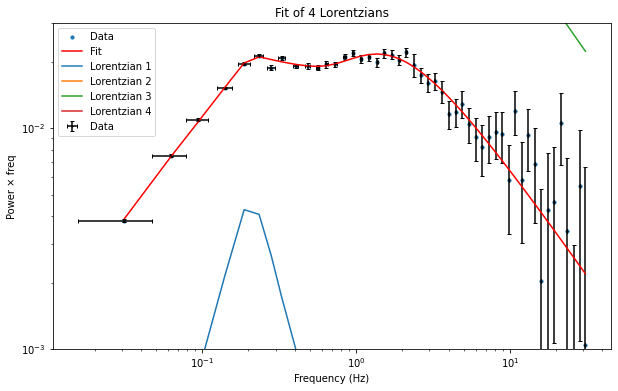

59.29737017912675
Degrees of freedom: 37
Reduced chi-squared: 1.6026316264628853
37


In [108]:
init_centers = [0.05, 1.18/2, 1.18, 0.001]
init_fwhm = [0.2, 0.97/2, 0.97, 5]
init_amplitudes = [0.1, 0.01, 0.03, 0.05]

# Convert FWHM to gamma (gamma = FWHM/2)
init_gamma = [fw/2 for fw in init_fwhm]

# Build p0 = [x01, gamma1, A1, x02, gamma2, A2, ...]
p0 = []
for xc, g, A in zip(init_centers, init_gamma, init_amplitudes):
    p0.extend([xc, g, A])

print("p0 =", p0)



import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a Lorentzian function
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

# Define the sum of 4 Lorentzians
def four_lorentzians(x, x01, gamma1, A1,
                        x02, gamma2, A2,
                        x03, gamma3, A3,
                        x04, gamma4, A4):
    return (lorentzian(x, x01, gamma1, A1) +
            lorentzian(x, x02, gamma2, A2) +
            lorentzian(x, x03, gamma3, A3) +
            lorentzian(x, x04, gamma4, A4))

# Example: generate some synthetic data

xdata = cs.freq
ydata = cs.power.real

yerr=np.array(np.real(cs.power_err))

# Fit the data
popt, pcov = curve_fit(four_lorentzians, xdata, ydata, p0=p0,sigma=yerr, absolute_sigma=True,maxfev=200000)

# Extract best-fit parameters
print("Best-fit parameters:", popt)

# Plot results
plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata,color='black' ,fmt='.', markersize=2, capsize=2, label="Data")
plt.scatter(xdata, ydata*xdata, s=10, label="Data")
plt.plot(xdata, four_lorentzians(xdata, *popt)*xdata, 'r-', label="Fit")

# Optionally plot individual Lorentzians
for i in range(4):
    xi, gi, Ai = popt[3*i:3*(i+1)]
    plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"Lorentzian {i+1}")

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-3,0.03)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title("Fit of 4 Lorentzians")
plt.show()

chi_sqr=np.sum(((ydata - four_lorentzians(xdata, *popt)) / yerr)**2)
print(chi_sqr)

dof=len(ydata)-len(popt)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)
print(dof)

Free fit parameters (10):
  x1     = 0.247295  ± 0.0776488
  x3     = 0.49467  ± 0.0803992
  x4     = -0.844067  ± 0.208873
  g1     = 0.171896  ± 0.0481303
  g3     = 0.343752  ± 0.0565511
  g4     = 0.0260581  ± 5.61303
  A1     = 73.0727  ± 208934
  A2     = -73.0478  ± 208934
  A3     = -0.0144082  ± 0.0066862
  A4     = 121.941  ± 52531.1

Full parameters (12, with ties):
  x1   = 0.247295  ± 0.0776488
  g1   = 0.171896  ± 0.0481303
  A1   = 73.0727  ± 208934
  x2   = 0.247335  ± 0.0401996
  g2   = 0.171876  ± 0.0282755
  A2   = -73.0478  ± 208934
  x3   = 0.49467  ± 0.0803992
  g3   = 0.343752  ± 0.0565511
  A3   = -0.0144082  ± 0.0066862
  x4   = -0.844067  ± 0.208873
  g4   = 0.0260581  ± 5.61303
  A4   = 121.941  ± 52531.1

Chi2 = 62.11, reduced Chi2 = 1.592 (ndof = 39)


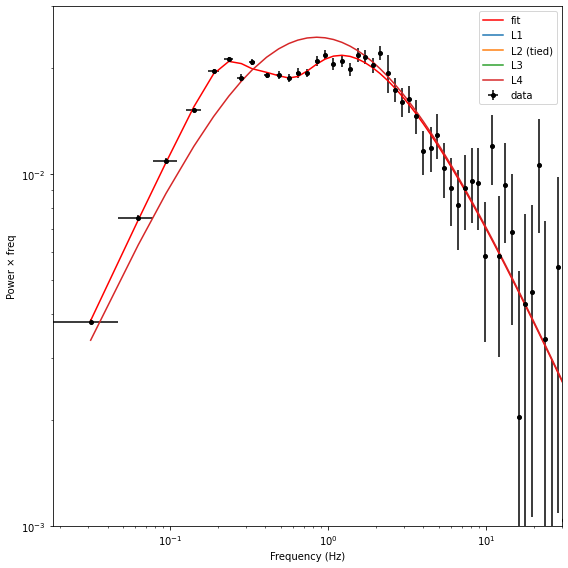

In [14]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# -------------------------
# Your initial guesses
init_centers = [0.05, 1.18/2, 1.18, 0.001]
init_fwhm = [0.2, 0.97/2, 0.97, 5]
init_amplitudes = [0.1, 0.01, 0.03, 0.05]

# Convert FWHM -> gamma = FWHM/2
init_gamma = [fw/2 for fw in init_fwhm]

# Build initial parameter vector for tied model
# Free params order: [x1, x3, x4, gamma1, gamma3, gamma4, A1, A2, A3, A4]
p0_tied = [
    init_centers[0],   # x1
    init_centers[2],   # x3
    init_centers[3],   # x4
    init_gamma[0],     # g1
    init_gamma[2],     # g3
    init_gamma[3],     # g4
    init_amplitudes[0],# A1
    init_amplitudes[1],# A2
    init_amplitudes[2],# A3
    init_amplitudes[3] # A4
]

# -------------------------
# Lorentzian
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

# Model with ties
def four_lorentzians_tied(x, x1, x3, x4, gamma1, gamma3, gamma4, A1, A2, A3, A4):
    x2 = 0.5 * x3
    g2 = 0.5 * gamma3
    return (lorentzian(x, x1, gamma1, A1) +
            lorentzian(x, x2, g2, A2) +
            lorentzian(x, x3, gamma3, A3) +
            lorentzian(x, x4, gamma4, A4))

# -------------------------
# Your data
ydata = cs.power.real
xdata = cs.freq
yerr = np.array(np.real(cs.power_err))

# Fit
popt, pcov = curve_fit(four_lorentzians_tied, xdata, ydata, p0=p0_tied,
                       sigma=yerr, absolute_sigma=True, maxfev=500000)
perr_free = np.sqrt(np.diag(pcov))

param_names_free = ["x1","x3","x4","g1","g3","g4","A1","A2","A3","A4"]

# -------------------------
# Expand to full 12 parameters
def build_full_params(popt, perr_free):
    x1, x3, x4, g1, g3, g4, A1, A2, A3, A4 = popt
    x2 = 0.5 * x3
    g2 = 0.5 * g3
    full_params = np.array([x1, g1, A1,
                            x2, g2, A2,
                            x3, g3, A3,
                            x4, g4, A4])

    perr_full = np.zeros(12)
    perr_full[0]  = perr_free[0]   # x1
    perr_full[1]  = perr_free[3]   # g1
    perr_full[2]  = perr_free[6]   # A1
    perr_full[3]  = 0.5 * perr_free[1]   # x2 tied
    perr_full[4]  = 0.5 * perr_free[4]   # g2 tied
    perr_full[5]  = perr_free[7]   # A2
    perr_full[6]  = perr_free[1]   # x3
    perr_full[7]  = perr_free[4]   # g3
    perr_full[8]  = perr_free[8]   # A3
    perr_full[9]  = perr_free[2]   # x4
    perr_full[10] = perr_free[5]   # g4
    perr_full[11] = perr_free[9]   # A4

    return full_params, perr_full

full_params, perr_full = build_full_params(popt, perr_free)

# -------------------------
# Print results
print("Free fit parameters (10):")
for name, val, err in zip(param_names_free, popt, perr_free):
    print(f"  {name:6s} = {val:.6g}  ± {err:.6g}")

param_names_full = ["x1","g1","A1","x2","g2","A2","x3","g3","A3","x4","g4","A4"]
print("\nFull parameters (12, with ties):")
for name, val, err in zip(param_names_full, full_params, perr_full):
    print(f"  {name:4s} = {val:.6g}  ± {err:.6g}")

# -------------------------
# Chi-square
yfit = four_lorentzians_tied(xdata, *popt)
chi2 = np.sum(((ydata - yfit) / yerr) ** 2)
ndof = len(xdata) - len(popt)
chi2_red = chi2 / ndof
print(f"\nChi2 = {chi2:.4g}, reduced Chi2 = {chi2_red:.4g} (ndof = {ndof})")

# -------------------------
# Plot
plt.figure(figsize=(8,8))
plt.errorbar(xdata, ydata * xdata, xerr=(cs.df/2),
             yerr=(yerr * xdata), color='black', fmt='o', ms=4, label='data')
plt.plot(xdata, yfit * xdata, label='fit', color='red')

x = xdata
x1, x3, x4, g1, g3, g4, A1, A2, A3, A4 = popt
x2 = 0.5 * x3
g2 = 0.5 * g3

comp1 = lorentzian(x, x1, g1, A1)
comp2 = lorentzian(x, x2, g2, A2)
comp3 = lorentzian(x, x3, g3, A3)
comp4 = lorentzian(x, x4, g4, A4)

plt.plot(x, comp1 * x, label='L1')
plt.plot(x, comp2 * x, label='L2 (tied)')
plt.plot(x, comp3 * x, label='L3')
plt.plot(x, comp4 * x, label='L4')

plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power × freq')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3, 0.03)
plt.xlim(0.018, 30)
plt.tight_layout()
plt.show()


p0 = [0.3, 0.1, 0.1, 1, 0.2, 0.01, 2, 0.4, 0.03, 6, 2.5, 0.05]
Best-fit parameters: [6.25551409e-02 2.59365185e-01 1.15970523e-01 8.81922058e-01
 2.70549876e-01 6.54144966e-03 1.56040109e+00 1.21787810e+00
 8.29159189e-03 2.98727329e+00 8.15024551e+00 9.87407373e-04]


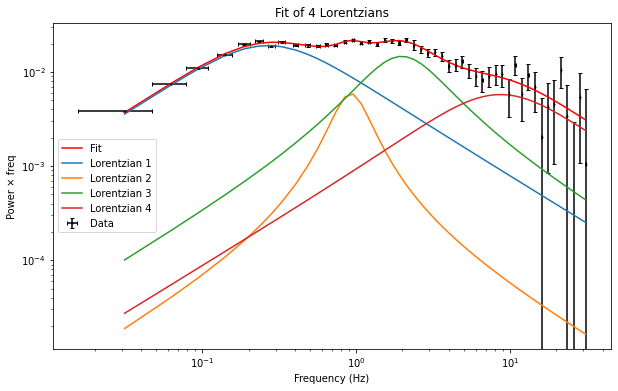

Chi-squared: 73.35893675006221
Degrees of freedom: 39
Reduced chi-squared: 1.8809983782067234


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# General Lorentzian
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

# General sum of n Lorentzians
def n_lorentzians(x, *params):
    """
    params: [x01, gamma1, A1, x02, gamma2, A2, ..., x0n, gamman, An]
    """
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        xi, gi, Ai = params[3*i:3*(i+1)]
        y += lorentzian(x, xi, gi, Ai)
    return y

# Example: your initial guesses
#init_centers = [0.05, 1.18/2]#, 1.18]#, 0.001]  # can be any length
#init_fwhm = [0.2, 0.97/2]#, 0.97]#, 5]
#init_amplitudes = [0.1, 0.01]#, 0.03]#, 0.05]

init_centers = [0.3, 1, 2, 6]  # can be any length
init_fwhm = [0.2, 0.8/2, 0.8, 5]
init_amplitudes = [0.1, 0.01, 0.03, 0.05]

# Convert FWHM to gamma
init_gamma = [fw/2 for fw in init_fwhm]

# Flatten initial parameters into p0
p0 = []
for xc, g, A in zip(init_centers, init_gamma, init_amplitudes):
    p0.extend([xc, g, A])
print("p0 =", p0)
# Example data
xdata = cs.freq
ydata = cs.power.real
yerr = np.array(np.real(cs.power_err))

# Fit
popt, pcov = curve_fit(n_lorentzians, xdata, ydata, p0=p0, sigma=yerr, absolute_sigma=True, maxfev=20000000)

print("Best-fit parameters:", popt)

# Plot results
plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata, fmt='.', markersize=2, capsize=2, color='black', label="Data")
plt.plot(xdata, n_lorentzians(xdata, *popt)*xdata, 'r-', label="Fit")

# Individual Lorentzians
n = len(popt)//3 
for i in range(n):
    xi, gi, Ai = popt[3*i:3*(i+1)]
    plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"Lorentzian {i+1}")

plt.legend()
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-3, 0.03)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title(f"Fit of {n} Lorentzians")
plt.show()

# Chi-squared
chi_sqr = np.sum(((ydata - n_lorentzians(xdata, *popt)) / yerr)**2)
dof = len(ydata) - len(popt)+2
print("Chi-squared:", chi_sqr)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)


Initial parameters: [0.3, 0.1, 0.1, 0.01, 2, 0.4, 0.03, 6, 2.5, 0.05]
Best-fit parameters: [ 6.42267385e-02  2.54923019e-01  1.14943774e-01  8.14655057e-03
  1.81079496e+00  7.97812720e-01  5.39003647e-03 -2.52658584e-01
  4.94514862e+00  3.44328029e-03]


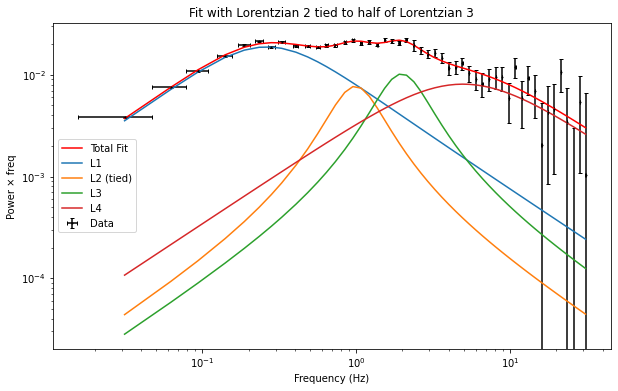

Chi-squared: 76.32096267418538
Degrees of freedom: 39
Reduced chi-squared: 1.9569477608765482


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Lorentzian function ---
def lorentzian(x, x0, gamma, A):
    return (A * (gamma**2)) / ((x - x0)**2 + gamma**2)

# --- Model with Lorentzian #2 tied to half of #3 ---
def lorentzians_tied_2nd_to_3rd(x,
                                x01, gamma1, A1,   # Lorentzian 1 free
                                A2,               # Lorentzian 2 amplitude free
                                x03, gamma3, A3,   # Lorentzian 3 free
                                *rest):            # Extra Lorentzians (optional)
    
    # Tied parameters:
    x02 = 0.5 * x03
    gamma2 = 0.5 * gamma3
    
    y = lorentzian(x, x01, gamma1, A1)
    y += lorentzian(x, x02, gamma2, A2)
    y += lorentzian(x, x03, gamma3, A3)

    # Add any extra Lorentzians normally
    if len(rest) > 0:
        n_extra = len(rest)//3
        for i in range(n_extra):
            xi, gi, Ai = rest[3*i : 3*(i+1)]
            y += lorentzian(x, xi, gi, Ai)

    return y


# --- Initial guess setup ---
init_centers = [0.3, 1, 2, 6]
init_fwhm = [0.2, 0.8/2, 0.8, 5]
init_amplitudes = [0.1, 0.01, 0.03, 0.05]

# Convert FWHM → gamma
init_gamma = [fw/2 for fw in init_fwhm]

# Extract parameters for the first three Lorentzians (with ties applied to #2)
x01, gamma1, A1 = init_centers[0], init_gamma[0], init_amplitudes[0]
A2 = init_amplitudes[1]  # amplitude remains free
x03, gamma3, A3 = init_centers[2], init_gamma[2], init_amplitudes[2]

# Any additional Lorentzians passed through unchanged:
extra = []
for xc, g, A in zip(init_centers[3:], init_gamma[3:], init_amplitudes[3:]):
    extra.extend([xc, g, A])

# Construct new parameter vector:
p0 = [x01, gamma1, A1, A2, x03, gamma3, A3] + extra
print("Initial parameters:", p0)

# --- Load your data ---
xdata = cs.freq
ydata = cs.power.real
yerr = np.real(cs.power_err)

# --- Fit ---
popt, pcov = curve_fit(
    lorentzians_tied_2nd_to_3rd,
    xdata, ydata,
    p0=p0,
    sigma=yerr,
    absolute_sigma=True,
    maxfev=2000000
)

print("Best-fit parameters:", popt)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata,
             fmt='.', markersize=2, capsize=2, color='black', label="Data")

model = lorentzians_tied_2nd_to_3rd(xdata, *popt)
plt.plot(xdata, model*xdata, 'r-', label="Total Fit")

# Plot individual Lorentzians
# Recompute tied parameters for display
x01, gamma1, A1 = popt[0:3]
A2 = popt[3]
x03, gamma3, A3 = popt[4:7]

x02 = 0.5 * x03
gamma2 = 0.5 * gamma3

plt.plot(xdata, lorentzian(xdata, x01, gamma1, A1)*xdata, '-', label="L1")
plt.plot(xdata, lorentzian(xdata, x02, gamma2, A2)*xdata, '-', label="L2 (tied)")
plt.plot(xdata, lorentzian(xdata, x03, gamma3, A3)*xdata, '-', label="L3")

# Extra Lorentzians:
rest = popt[7:]
if len(rest) > 0:
    for i in range(len(rest)//3):
        xi, gi, Ai = rest[3*i:3*(i+1)]
        plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"L{4+i}")

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title("Fit with Lorentzian 2 tied to half of Lorentzian 3")
plt.show()

# --- χ² ---
chi_sqr = np.sum(((ydata - model) / yerr)**2)
dof = len(ydata) - len(popt) 
print("Chi-squared:", chi_sqr)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)


Automatically generated initial guesses (p0): [7.3125, 0.619375, 0.0012521249122895046, 10.859375, 0.619375, 0.0011059143851322444]
Best-fit parameters: [0.06991168 0.22897345 0.10591991 0.436076   1.77735731 0.01578014]


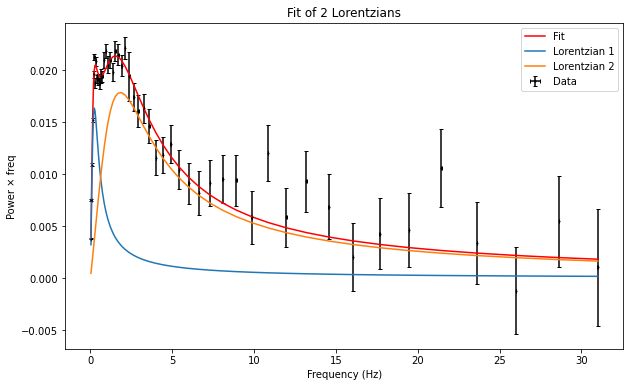

Chi-squared: 105.01990455544446
Degrees of freedom: 43
Reduced chi-squared: 2.4423233617545224


In [109]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# --- Lorentzian functions ---
def lorentzian(x, x0, gamma, A):
    return (A * gamma**2) / ((x - x0)**2 + gamma**2)

def n_lorentzians(x, *params):
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        xi, gi, Ai = params[3*i:3*(i+1)]
        y += lorentzian(x, xi, gi, Ai)
    return y

# --- User-defined number of Lorentzians to fit ---
n_peaks_to_fit = 4  # <-- set this to the number of Lorentzians you want

# --- Prepare data ---
xdata = np.asarray(cs.freq).ravel()
ydata = np.asarray(cs.power.real).ravel()
yerr = np.asarray(np.real(cs.power_err)).ravel()

# If yerr is a single number, expand to array
if yerr.size == 1:
    yerr = np.full_like(ydata, yerr)

# --- Automatic initial guess using peaks ---
threshold_fraction = 0.05  # start at 5% of max
peaks = []
properties = {}
while len(peaks) == 0 and threshold_fraction > 1e-4:
    peaks, properties = find_peaks(ydata, height=np.max(ydata)*threshold_fraction)
    threshold_fraction /= 2

# --- Determine initial guesses ---
if len(peaks) == 0:
    # No peaks detected: evenly spaced initial guesses
    print(f"No peaks detected. Using {n_peaks_to_fit} evenly spaced Lorentzians as initial guess.")
    init_centers = np.linspace(xdata[0], xdata[-1], n_peaks_to_fit)
    init_amplitudes = np.full(n_peaks_to_fit, np.max(ydata)/2)
    init_gamma = np.full(n_peaks_to_fit, (xdata[-1]-xdata[0])/20)
else:
    # Peaks detected: choose up to n_peaks_to_fit highest peaks
    peak_heights = properties["peak_heights"]
    if len(peaks) > n_peaks_to_fit:
        idx_sort = np.argsort(peak_heights)[-n_peaks_to_fit:]  # indices of largest peaks
    else:
        idx_sort = np.arange(len(peaks))
    init_centers = xdata[peaks][idx_sort]
    init_amplitudes = peak_heights[idx_sort]
    init_gamma = np.full(len(init_centers), (xdata[-1]-xdata[0])/50)

# Flatten initial parameters for curve_fit
p0 = []
for xc, g, A in zip(init_centers, init_gamma, init_amplitudes):
    p0.extend([xc, g, A])

print("Automatically generated initial guesses (p0):", p0)

# --- Fit ---
popt, pcov = curve_fit(
    n_lorentzians, xdata, ydata,
    p0=p0, sigma=yerr, absolute_sigma=True, maxfev=20000000
)

print("Best-fit parameters:", popt)

# --- Plot results ---
plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata, fmt='.', markersize=2, capsize=2, color='black', label="Data")
plt.plot(xdata, n_lorentzians(xdata, *popt)*xdata, 'r-', label="Fit")

# Individual Lorentzians
n = len(popt)//3
for i in range(n):
    xi, gi, Ai = popt[3*i:3*(i+1)]
    plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"Lorentzian {i+1}")

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title(f"Fit of {n} Lorentzians")
plt.show()

# --- Chi-squared ---
chi_sqr = np.sum(((ydata - n_lorentzians(xdata, *popt)) / yerr)**2)
dof = len(ydata) - len(popt)
print("Chi-squared:", chi_sqr)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)


Automatically generated initial guesses for 4 Lorentzians (p0):
[7.3125, 0.619375, 0.0012521249122895046, 10.859375, 0.619375, 0.0011059143851322444, 13.203125, 0.619375, 0.0007060566110290093, 21.453125, 0.619375, 0.0004945134373882324]
Best-fit parameters: [ 6.71104524e-02  2.37631638e-01  1.09361028e-01  4.90781531e+00
  2.62315293e-03  5.54015869e-04  7.78109017e-01 -1.55105100e+00
  1.39425482e-02  9.91249462e+00 -5.79506055e+00  4.18850011e-04]


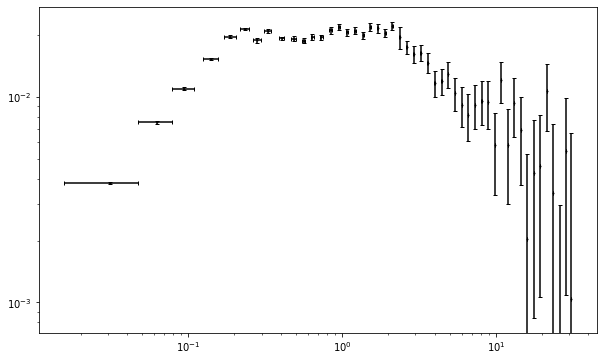

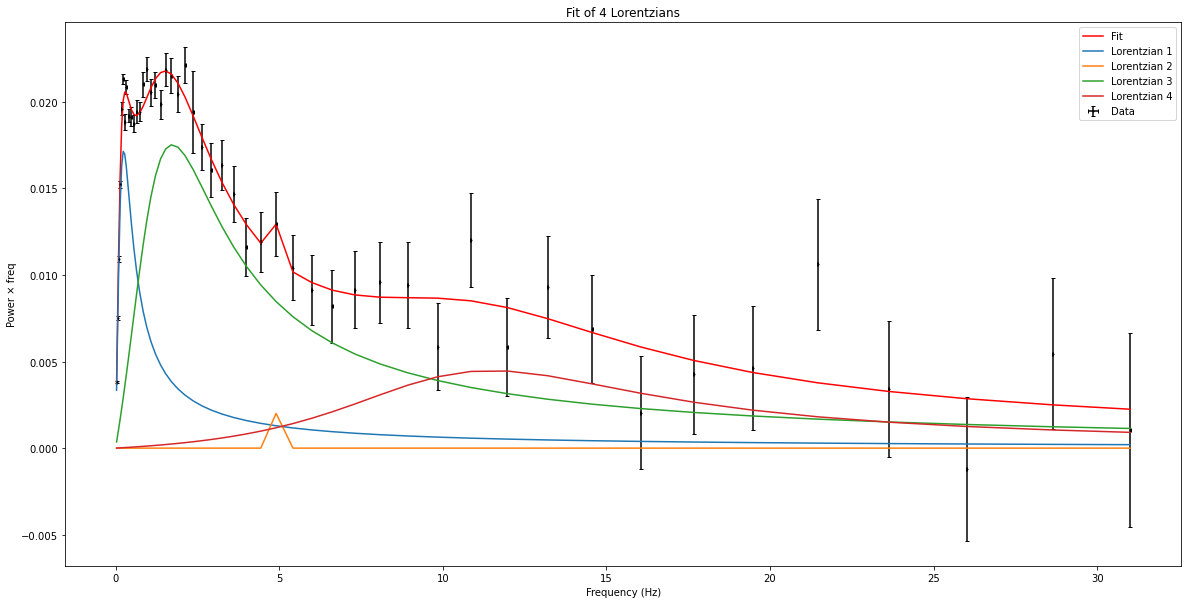

Chi-squared: 92.2508902159956
Degrees of freedom: 37
Reduced chi-squared: 2.493267303135016


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# --- Lorentzian functions ---
def lorentzian(x, x0, gamma, A):
    return (A * gamma**2) / ((x - x0)**2 + gamma**2)

def n_lorentzians(x, *params):
    n = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n):
        xi, gi, Ai = params[3*i:3*(i+1)]
        y += lorentzian(x, xi, gi, Ai)
    return y

# --- User-defined number of Lorentzians to fit ---
n_peaks_to_fit = 4# <-- set this to the exact number of Lorentzians you want

# --- Prepare data ---
xdata = np.asarray(cs.freq).ravel()
ydata = np.asarray(cs.power.real).ravel()
yerr = np.asarray(np.real(cs.power_err)).ravel()

# If yerr is a single number, expand to array
if yerr.size == 1:
    yerr = np.full_like(ydata, yerr)

# --- Automatic initial guess using peaks ---
threshold_fraction = 0.0005  # start at 5% of max
peaks = []
properties = {}
while len(peaks) == 0 and threshold_fraction > 1e-4:
    peaks, properties = find_peaks(ydata, height=np.max(ydata)*threshold_fraction)
    threshold_fraction /= 2

# --- Determine exactly n_peaks_to_fit initial guesses ---
init_centers = []
init_amplitudes = []

if len(peaks) > 0:
    peak_heights = properties["peak_heights"]
    idx_sort = np.argsort(peak_heights)[::-1]  # sort descending
    for i in idx_sort:
        init_centers.append(xdata[peaks[i]])
        init_amplitudes.append(peak_heights[i])
    # trim if more than needed
    init_centers = init_centers[:n_peaks_to_fit]
    init_amplitudes = init_amplitudes[:n_peaks_to_fit]

# Fill remaining guesses with evenly spaced points
remaining = n_peaks_to_fit - len(init_centers)
if remaining > 0:
    filler_centers = np.linspace(xdata[0], xdata[-1], remaining+2)[1:-1]  # avoid exact edges
    filler_amplitudes = np.full(remaining, np.max(ydata)/2)
    init_centers.extend(filler_centers)
    init_amplitudes.extend(filler_amplitudes)

# Set gammas
init_gamma = np.full(n_peaks_to_fit, (xdata[-1]-xdata[0])/50)

# Flatten initial parameters for curve_fit
p0 = []
for xc, g, A in zip(init_centers, init_gamma, init_amplitudes):
    p0.extend([xc, g, A])

print(f"Automatically generated initial guesses for {n_peaks_to_fit} Lorentzians (p0):")
print(p0)

# --- Fit ---
popt, pcov = curve_fit(
    n_lorentzians, xdata, ydata,
    p0=p0, sigma=yerr, absolute_sigma=True, maxfev=20000000
)

print("Best-fit parameters:", popt)

plt.figure(figsize=(10,6))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata, fmt='.', markersize=2, capsize=2, color='black', label="Data")
plt.xscale("log")
plt.yscale("log")

# --- Plot results ---
plt.figure(figsize=(20,10))
plt.errorbar(xdata, ydata*xdata, xerr=cs.df/2, yerr=yerr*xdata, fmt='.', markersize=2, capsize=2, color='black', label="Data")
plt.plot(xdata, n_lorentzians(xdata, *popt)*xdata, 'r-', label="Fit")
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim(2e-3,0.03)

# Individual Lorentzians
n = len(popt)//3
for i in range(n):
    xi, gi, Ai = popt[3*i:3*(i+1)]
    plt.plot(xdata, lorentzian(xdata, xi, gi, Ai)*xdata, '-', label=f"Lorentzian {i+1}")

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power × freq")
plt.title(f"Fit of {n} Lorentzians")
plt.show()

# --- Chi-squared ---
chi_sqr = np.sum(((ydata - n_lorentzians(xdata, *popt)) / yerr)**2)
dof = len(ydata) - len(popt)
print("Chi-squared:", chi_sqr)
print("Degrees of freedom:", dof)
print("Reduced chi-squared:", chi_sqr/dof)


In [41]:
xerr=[cs.df/2]*len(xdata)

In [10]:
#save out data in plot

data_to_save = np.column_stack([
    xdata,           # Frequency
    ydata ,          # Original data
    xerr,
    yerr,   # Original data
    n_lorentzians(xdata, *popt),       # Total fit
    lorentzian(xdata, popt[0], popt[1], popt[2]),       # Comp 1
    lorentzian(xdata, popt[3], popt[4], popt
[5]),       # Comp 2

])

np.savetxt("lorentzian01250101_plt_data.txt", data_to_save,
           header="freq(Hz) power xerr yerr yfit comp1 comp2")

print("Data saved to fit_data.txt")

Data saved to fit_data.txt


In [11]:
Chi_squared_2= 105.01990457257531
Degrees_of_freedom_2= 43
Reduced_chi_squared_2= 2.4423233621529143

In [12]:
Chi_squared_3= 59.29733367347459
Degrees_of_freedom_3= 40
Reduced_chi_squared_3= 1.4824333418368647

In [ ]:
0.06991181 0.2289731  0.10591985

0.4360704  1.77735619 0.0157802